## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable
from helpers import PlotROCCurve
from dataset_path import output_path

path = "/mnt/mimic/mgrzeszczyk/data/ed"
output_path = os.path.join(path, "Task2")

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2024-12-02 18:38:52.032263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733182732.056054 3170187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733182732.062201 3170187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 18:38:52.087772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,36.888889,70.0,16.0,97.0,106.0,63.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.500000,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,77.333333,1,0,2,1,1,1
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.62,NaN,25.79,37.166667,88.0,18.0,97.0,116.0,88.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.611111,86.0,17.0,93.0,96.0,57.0,5.0,3.0,12.0,97.333333,6,0,2,0,0,1
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,36.555556,87.0,14.0,97.0,71.0,43.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,36.777778,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,52.333333,6,4,4,3,3,2
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True,2,3,3,2180-08-05 20:58:00,13 days 06:58:00,False,1,2,2,0,0,0,8.10,0.0,13.29,37.055556,77.0,16.0,98.0,96.0,50.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,37.222222,96.0,18.0,97.0,86.0,45.0,0.0,8.0,14.0,65.333333,6,0,4,2,2,2
4,2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,Medicaid,2180,52,False,0 days 04:46:00,NaN,NaN,False,True,False,2,3,4,NaN,NaN,False,1,2,3,1,1,1,4.77,NaN,NaN,37.444444,105.0,18.0,96.0,106.0,57.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,36.722222,91.0,18.0,99.0,98.0,60.0,0.0,6.0,7.0,73.333333,6,0,2,2,2,2


### 1. Task-specific filter: no task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 376302 , testing size = 41798


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06335144666457558 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 10.651946783065796 seconds
AUC: 0.8692057801236895
AUPRC: 0.32660993507948544
Sensitivity: 0.8044354838709677
Specificity: 0.7773793173610051
Score thresold: 0.06284743549764256
2.5 97.5


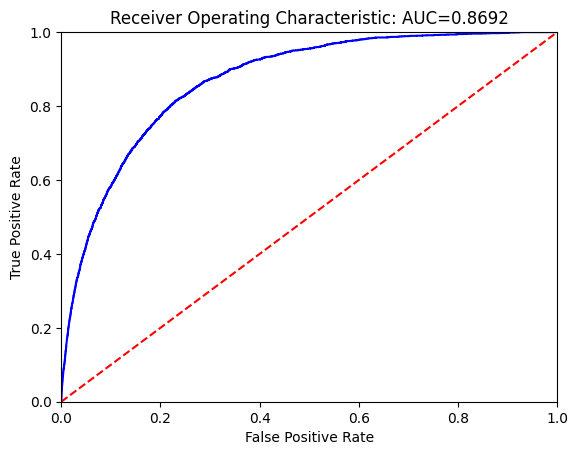

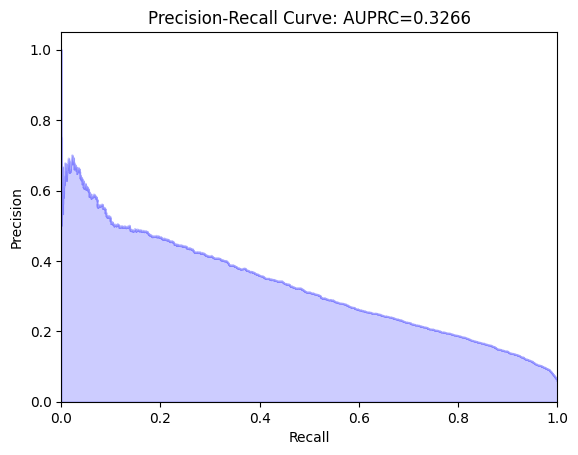

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 84.31207466125488 seconds
AUC: 0.8752171192214352
AUPRC: 0.3851276028771107
Sensitivity: 0.8133064516129033
Specificity: 0.7852637468843786
Score thresold: 0.08
2.5 97.5


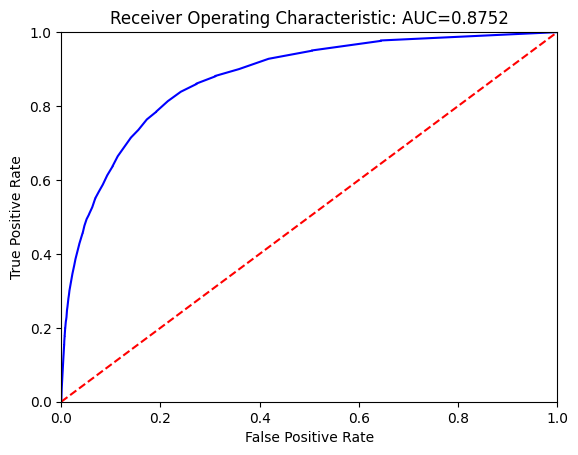

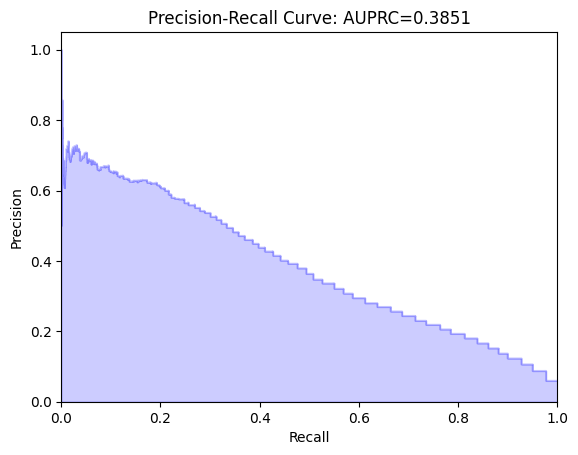

[0.09918639 0.01491019 0.00639139 0.01011136 0.01889512 0.00621209
 0.01005354 0.01691337 0.00323986 0.00680536 0.01207813 0.07642106
 0.09448074 0.05660476 0.05015137 0.10009664 0.0832138  0.04086548
 0.09044554 0.0059127  0.00644514 0.00398601 0.00153079 0.00223659
 0.00239934 0.0030537  0.00471841 0.003485   0.00315927 0.0051077
 0.00573198 0.00499289 0.00516254 0.00286574 0.00736991 0.00268085
 0.00271403 0.00470968 0.00753923 0.00470481 0.00241037 0.00504119
 0.00543876 0.00291512 0.00398817 0.00115157 0.00735838 0.00474657
 0.00437599 0.00500876 0.00893896 0.00588412 0.00565243 0.00174963
 0.00547199 0.00562003 0.00462476 0.0069816  0.00233246 0.00454178
 0.00489791 0.00377525 0.00247367 0.00703802]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 84.18375253677368 seconds
AUC: 0.8835247420126051
AUPRC: 0.40439664128418773
Sensitivity: 0.8044354838709677
Specificity: 0.7991759499465894
Score thresold: 0.06747353649076182
2.5 97.5


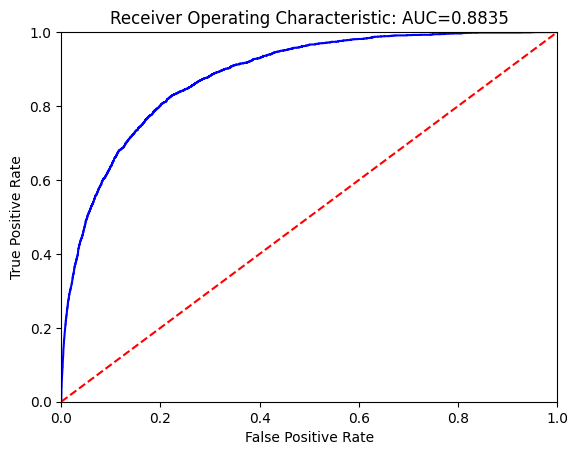

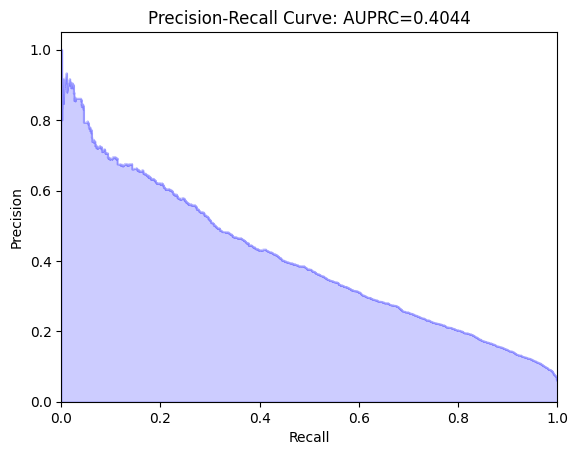

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
@register_keras_serializable()
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [17]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC',  metrics.AUC(name='auprc', curve='PR'),
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp.keras')

Epoch 1/20


I0000 00:00:1733183035.185943 3170187 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 594 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:13:00.0, compute capability: 8.0
I0000 00:00:1733183037.631306 3171265 service.cc:148] XLA service 0x7f4e40006930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733183037.631432 3171265 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-12-02 18:43:57.718292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733183037.898768 3171265 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-02 18:43:59.541921: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_567', 4 bytes spill 

  36/1882 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.4654 - Precision: 0.0286 - Recall: 0.0670 - TrueNegatives: 3241.6111 - TruePositives: 7.1111 - accuracy: 0.8228 - auprc: 0.0516 - loss: 1.4596

I0000 00:00:1733183041.293018 3171265 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1871/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7422 - Precision: 0.3326 - Recall: 0.0618 - TrueNegatives: 174841.4844 - TruePositives: 798.3170 - accuracy: 0.9340 - auprc: 0.1876 - loss: 0.2745

2024-12-02 18:44:07.275674: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 32 bytes spill stores, 32 bytes spill loads



1882/1882 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.7426 - Precision: 0.3333 - Recall: 0.0620 - TrueNegatives: 175961.6406 - TruePositives: 806.0165 - accuracy: 0.9340 - auprc: 0.1880 - loss: 0.2740
Epoch 2/20
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8500 - Precision: 0.5194 - Recall: 0.1359 - TrueNegatives: 175724.9531 - TruePositives: 1541.2894 - accuracy: 0.9408 - auprc: 0.3207 - loss: 0.1740
Epoch 3/20
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8606 - Precision: 0.5551 - Recall: 0.1490 - TrueNegatives: 175803.0312 - TruePositives: 1651.5156 - accuracy: 0.9421 - auprc: 0.3447 - loss: 0.1692
Epoch 4/20
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8633 - Precision: 0.5449 - Recall: 0.1389 - TrueNegatives: 175954.4531 - TruePositives: 1582.1625 - accuracy: 0.9421 - auprc: 0.3387 - loss: 0.1678
Epoch 5/20
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8700 - Precision: 0.5714 - Recall: 0.1476 - TrueNegatives: 176006.1719 - TruePositives: 1656.9517 - accu

MLP:
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
AUC: 0.8875254438991252
AUPRC: 0.3966982976072752
Sensitivity: 0.8165322580645161
Specificity: 0.7953609034030216
Score thresold: 0.07611194
2.5 97.5


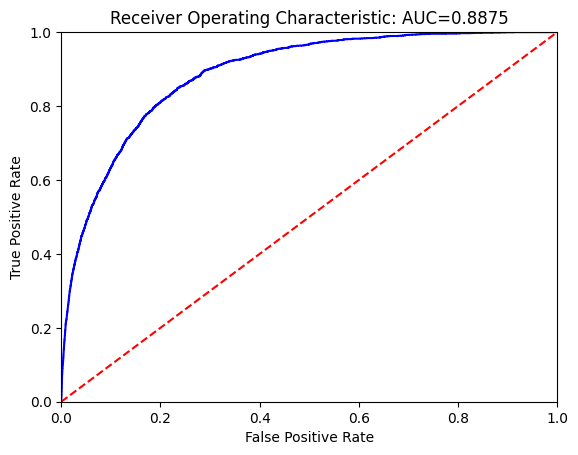

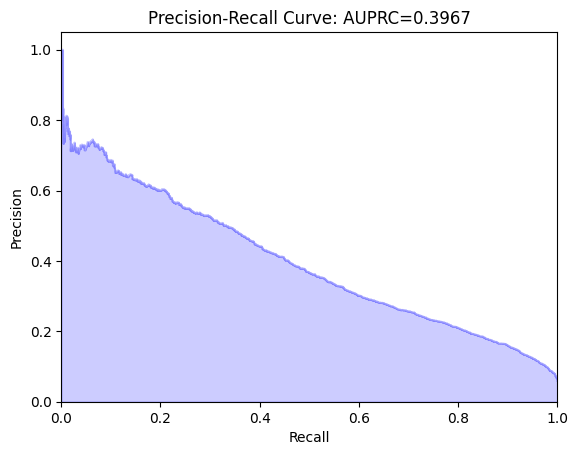

In [18]:
print("MLP:")
# mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [19]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8069118900643061
AUPRC: 0.1979463447450984
Sensitivity: 0.8774193548387097
Specificity: 0.64041914644692
Score thresold: -2.0
2.5 97.5


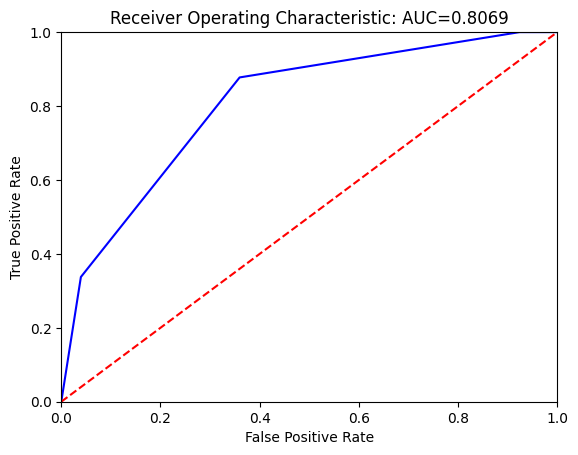

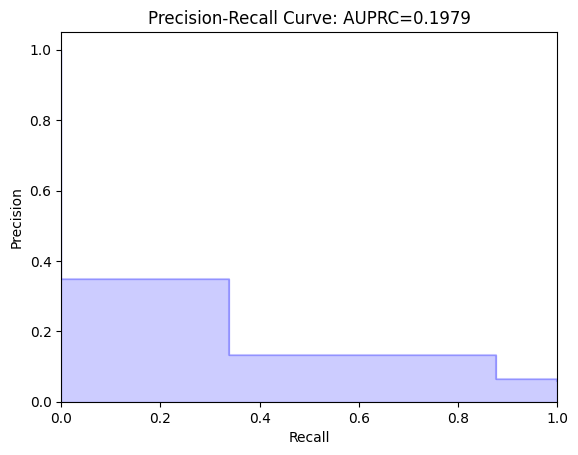

In [20]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

In [19]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore) # TODO add AutoScore
# AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Crtical.csv')))
# df_test["AutoScore"] = AutoScore_pred["pred_score"]
# get_score_performance("AutoScore", random_seed=random_seed)

score_NEWS
AUC: 0.6379505293069414
AUPRC: 0.15484953134715268
Sensitivity: 0.45806451612903226
Specificity: 0.7982603387761331
Score thresold: 2.0
2.5 97.5


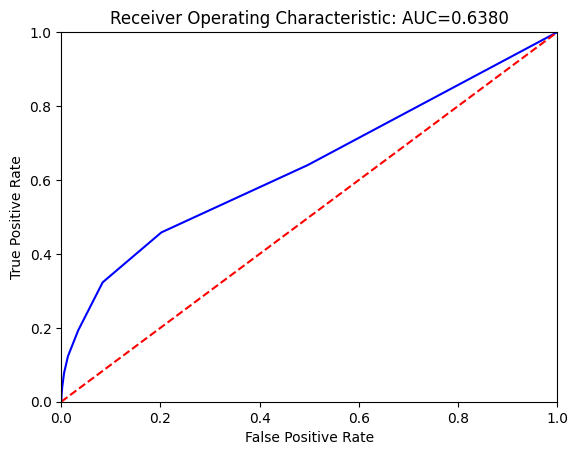

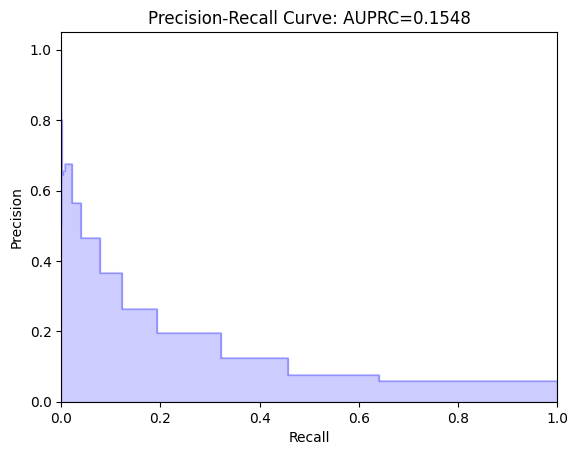

In [21]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6213688858751388
AUPRC: 0.14107468624227415
Sensitivity: 0.5959677419354839
Specificity: 0.5358614375095376
Score thresold: 1.0
2.5 97.5


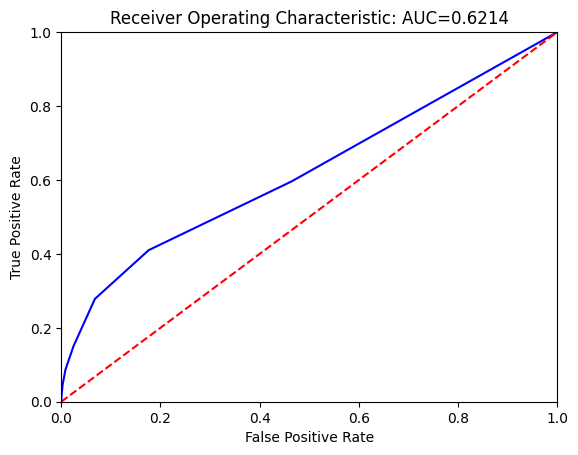

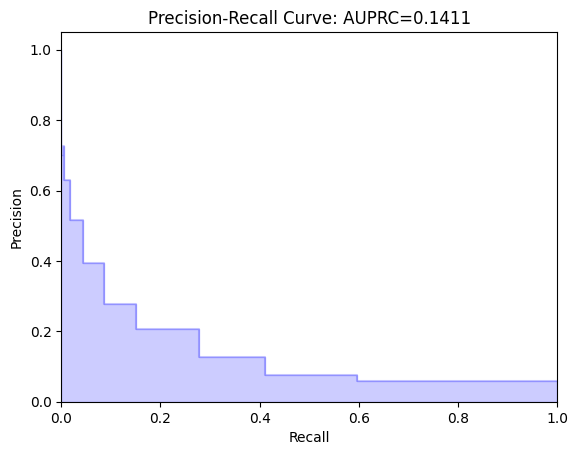

In [22]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6789187296633405
AUPRC: 0.1093836113919825
Sensitivity: 0.6737903225806452
Specificity: 0.6048629126608678
Score thresold: 5.0
2.5 97.5


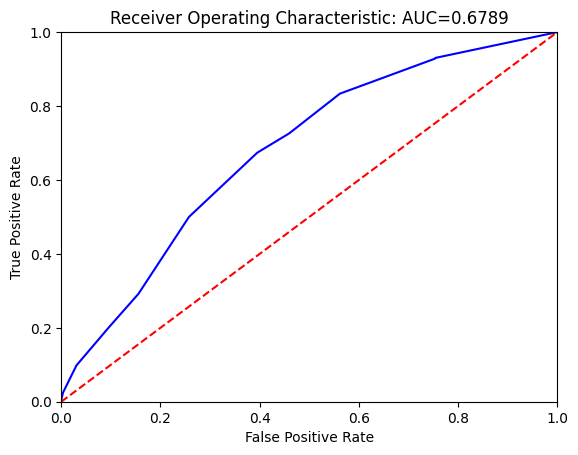

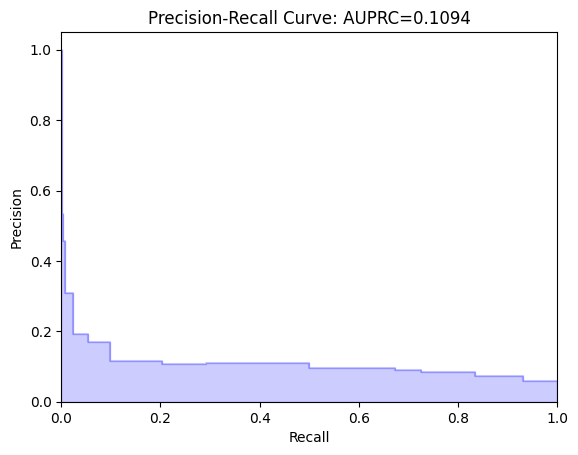

In [23]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.620990370699458
AUPRC: 0.11156000691202296
Sensitivity: 0.44193548387096776
Specificity: 0.7735134035301897
Score thresold: 2.0
2.5 97.5


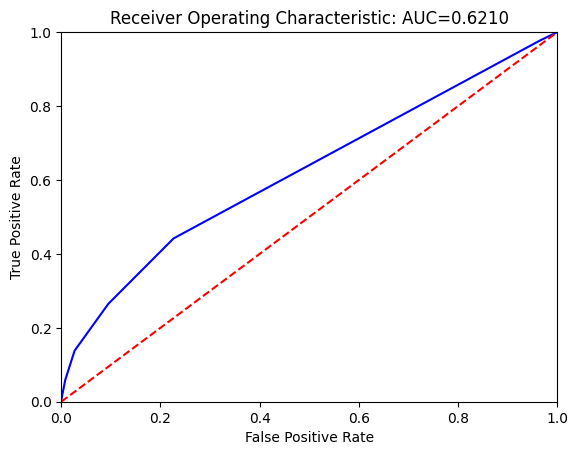

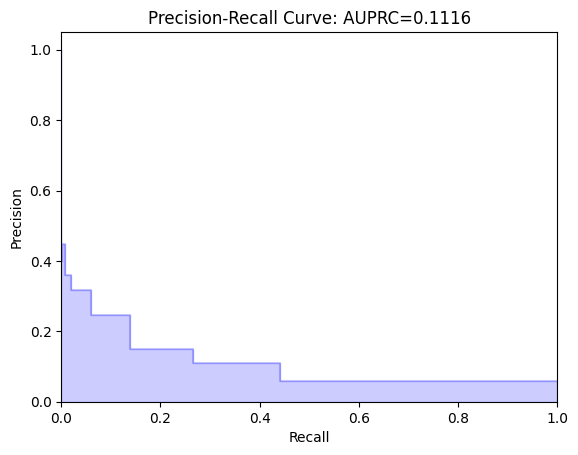

In [24]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7060912345818792
AUPRC: 0.15369292770174478
Sensitivity: 0.5907258064516129
Specificity: 0.7232819573732132
Score thresold: 6.0
2.5 97.5


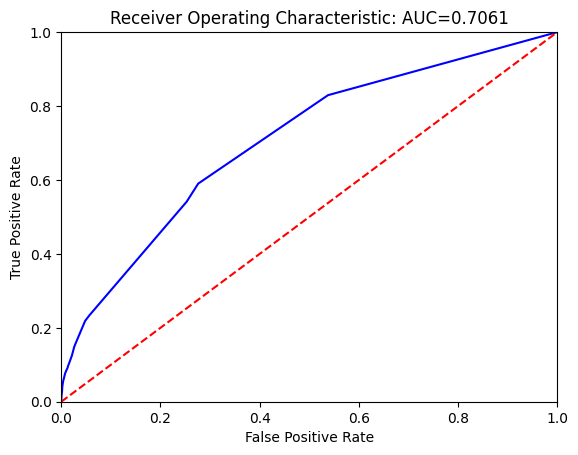

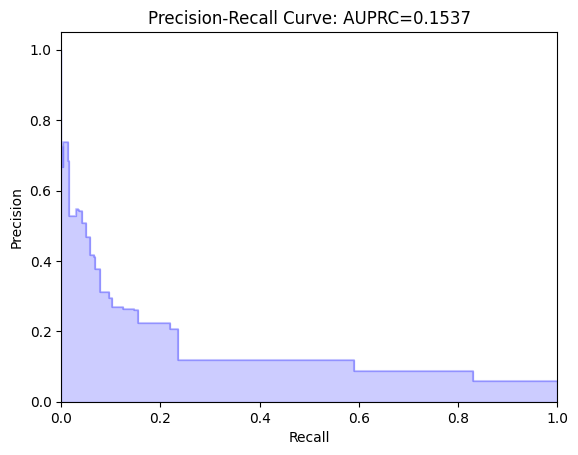

In [25]:
get_score_performance("score_CART", random_seed=random_seed)

In [30]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [ ]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [36]:
# To train from scratch, set load_model to None
load_model = None#"embedding_critical_"+version 
save_model = "embedding_critical_"+version + ".keras"

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC',  metrics.AUC(name='auprc', curve='PR'),
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'lambda_2' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ icd_input           │ (None, 14954)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 14954,     │ 15,313,920 │ icd_input[0][0]   │
│ (Embedding)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 14954,     │          0 │ embedding_2[0][0] │
│ (NotEqual)          │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 14954,     │          0 │ embedding_2[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 14954)     │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1024)      │          0 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    262,400 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demograph_input     │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 320)       │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ demograph_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     41,088 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 50)        │      6,450 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         51 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,623,909 (59.60 MB)

 Trainable params: 15,623,909 (59.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-12-02 18:53:39.004421: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 16 bytes spill stores, 16 bytes spill loads

2024-12-02 18:53:39.331962: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 148 bytes spill stores, 148 bytes spill loads

2024-12-02 18:53:39.476435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_904_0', 148 bytes spill stores, 108 bytes spill loads

2024-12-02 18:53:39.542814: I external/local_xla/xla/stream_executor/cuda/cuda_asm

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/runpy.py", line 88, in _run_code

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_3170187/3904741995.py", line 17, in <module>

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

Out of memory while trying to allocate 126873376 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_506573]

### 4. Performance output

In [26]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(output_path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.063,0.869 (0.864-0.872),0.327 (0.309-0.338),0.804 (0.795-0.822),0.777 (0.763-0.784),10.652
1,RF,0.080,0.875 (0.868-0.881),0.385 (0.368-0.405),0.813 (0.789-0.825),0.785 (0.783-0.809),84.312
2,GB,0.067,0.884 (0.88-0.887),0.404 (0.386-0.415),0.804 (0.799-0.829),0.799 (0.774-0.8),84.184
3,MLP,0.076,0.888 (0.883-0.891),0.397 (0.378-0.407),0.817 (0.803-0.838),0.795 (0.782-0.812),125.112
4,ESI,-2.000,0.807 (0.802-0.812),0.198 (0.188-0.207),0.877 (0.87-0.888),0.64 (0.637-0.644),0.000
5,score_NEWS,2.000,0.638 (0.625-0.654),0.155 (0.144-0.165),0.458 (0.439-0.48),0.798 (0.796-0.803),0.000
6,score_NEWS2,1.000,0.621 (0.609-0.635),0.141 (0.132-0.149),0.596 (0.404-0.612),0.536 (0.535-0.826),0.000
7,score_REMS,5.000,0.679 (0.668-0.689),0.109 (0.102-0.117),0.674 (0.656-0.693),0.605 (0.602-0.608),0.000
8,score_MEWS,2.000,0.621 (0.61-0.631),0.112 (0.106-0.117),0.442 (0.421-0.461),0.774 (0.77-0.778),0.000
9,score_CART,6.000,0.706 (0.695-0.713),0.154 (0.142-0.161),0.591 (0.569-0.603),0.723 (0.719-0.727),0.000


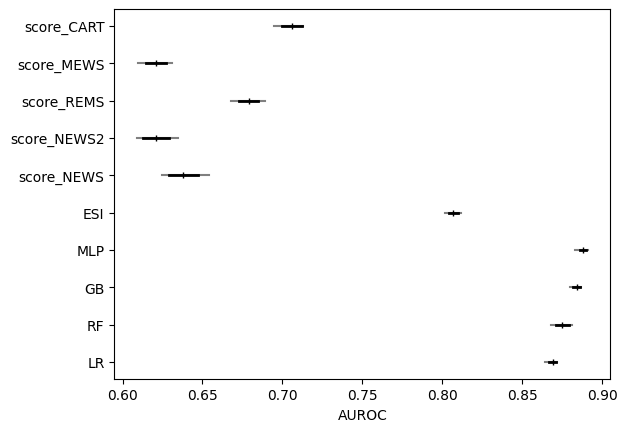

In [27]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

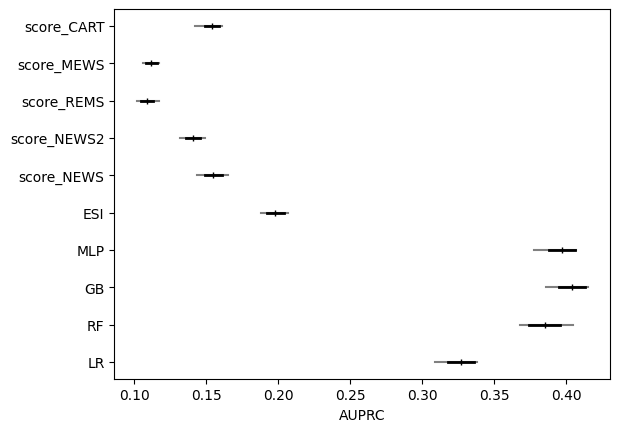

In [28]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [29]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(output_path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
15,triage_sbp,0.100097
0,age,0.099186
12,triage_heartrate,0.094481
18,triage_acuity,0.090446
16,triage_dbp,0.083214
11,triage_temperature,0.076421
13,triage_resprate,0.056605
14,triage_o2sat,0.050151
17,triage_pain,0.040865
4,n_ed_365d,0.018895
